In [92]:
import numpy as np
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

# Algoritmo Genético Binário em Passos:

1. **Representação binária**: Cada indivíduo da população é representado como um vetor binário.

2. **Função objetivo**: Avaliar cada indivíduo de acordo com a função de aptidão (fitness).

3. **Seleção**: Selecionar indivíduos com maior aptidão para reprodução.

4. **Cruzamento (crossover)**: Combinar partes dos bits de dois indivíduos (pais) para gerar novos indivíduos (filhos).

5. **Mutação**: Alterar aleatoriamente alguns bits dos indivíduos para manter diversidade.

6. **Convergência**: Repetir até atingir um critério de parada (número de gerações ou convergência).

## Gerar a População Inicial

In [93]:
def generate_pop(nvar, intervals, popsize):
    if nvar != len(intervals):
        raise ValueError("Número de variáveis não corresponde ao número de intervalos")
    return np.array([np.random.uniform(low, high, size=popsize) for low, high in intervals]).T

## Representação Binária

In [94]:
def normalize_pop(pop, intervals):
    intervals = np.array(intervals)
    return (pop - intervals[:, 0]) / (intervals[:, 1] - intervals[:, 0])

In [95]:
def unnormalize_pop(pop, intervals):
    intervals = np.array(intervals)
    return pop * (intervals[:, 1] - intervals[:, 0]) + intervals[:, 0]

In [96]:
def ga_encode(par, intervals, nbitg):
    norm_par = normalize_pop(par, intervals)
    scaled_par = (norm_par * (2**nbitg - 1)).astype(int)
    return np.unpackbits(scaled_par[:, :, np.newaxis].view(np.uint8), axis=-1)[:, :, -nbitg:].reshape(scaled_par.shape[0], -1)

In [97]:
def ga_decode(population, intervals, nbitg):
    popsize, nbitc = population.shape
    nvar = nbitc // nbitg
    bin_values = population.reshape(popsize, nvar, nbitg)
    quant = 2**np.arange(nbitg)[::-1]
    par = np.dot(bin_values, quant) / (2**nbitg - 1)
    return unnormalize_pop(par, intervals)

## Função Objetivo

In [98]:
def fitness_function(x):
    A = 5
    y = 2*A + (x[0]**2 - A*np.cos(2*np.pi*x[0])) + (x[1]**2 - A*np.cos(2*np.pi*x[1]))
    return y

## Seleção

In [99]:
def select_parents(pop_bin, intervals, nbitg, mode, percent_kept=0.5):
  if (mode == 'roulette'):
    pop = ga_decode(pop_bin.copy(), intervals, nbitg)

    fitness = np.apply_along_axis(fitness_function, 1, pop)

    constante_aditiva = abs(np.min(fitness)) + 1
    fitness_ajustados = fitness + constante_aditiva

    total_fitness = np.sum(fitness_ajustados)
    probabilities = fitness_ajustados / total_fitness

    size = int(pop.shape[0] * percent_kept)
    parents = np.random.choice(pop_bin.shape[0], size=size, p=probabilities, replace=False)

    new_pop = np.zeros(shape=pop_bin.shape)
    new_pop[0: size] = pop_bin[parents]

    return new_pop, size

## Cruzamento

In [100]:
def crossover(pop_bin, index):
    new_pop = pop_bin.copy()
    for i in range(index, pop_bin.shape[0] - 1, 2):
        parent1, parent2 = np.random.randint(0, index, size=2)
        cross_point = np.random.randint(1, pop_bin.shape[1])
        new_pop[i, :cross_point] = pop_bin[parent1, :cross_point]
        new_pop[i, cross_point:] = pop_bin[parent2, cross_point:]

        if i + 1 < pop_bin.shape[0]:
            new_pop[i + 1, :cross_point] = pop_bin[parent2, :cross_point]
            new_pop[i + 1, cross_point:] = pop_bin[parent1, cross_point:]

    return new_pop

## Mutação

In [101]:
def mutate(pop, pmut):
    mutation_mask = np.random.rand(*pop.shape) < pmut
    pop[mutation_mask] = 1 - pop[mutation_mask]
    return pop

## Substituição

In [102]:
def substitute(pop_ant, pop_prox, intervals, nbitg, prob):
    fitness_ant = np.apply_along_axis(fitness_function, 1, ga_decode(pop_ant, intervals, nbitg))
    fitness_prox = np.apply_along_axis(fitness_function, 1, ga_decode(pop_prox, intervals, nbitg))

    sorted_ant = pop_ant[np.argsort(fitness_ant) if prob == 'min' else np.argsort(fitness_ant)[::-1]]
    sorted_prox = pop_prox[np.argsort(fitness_prox) if prob == 'min' else np.argsort(fitness_prox)[::-1]]

    new_pop = np.vstack([sorted_ant[0], sorted_prox[:-1]])
    return new_pop

## Solução

In [103]:
def best_individual(pop, params):
    pop_decode = ga_decode(pop, params['intervals'], params['nbitg'])
    fitness = np.apply_along_axis(fitness_function, 1, pop_decode)
    best_index = np.argmax(fitness) if params['prob'] == 'max' else np.argmin(fitness)
    return pop_decode[best_index]

## Loop

In [104]:
def ga_bin(params):
    pop_bin = ga_encode(generate_pop(params['nvar'], params['intervals'], params['popsize']), params['intervals'], params['nbitg'])

    bests = [best_individual(pop_bin, params)]
    no_improvement_count = 0

    for iteration in range(params['max_iter']):
        parents, index = select_parents(pop_bin.copy(), params['intervals'], params['nbitg'],'roulette', params['percent_kept'])
        mating_pool = mutate(crossover(parents, index), params['pmut'])

        pop_bin = substitute(pop_bin, mating_pool, params['intervals'], params['nbitg'], params['prob'])
        bests.append(best_individual(pop_bin, params))

        fitness_diff = abs(fitness_function(bests[iteration]) - fitness_function(bests[iteration-1]))
        no_improvement_count = no_improvement_count + 1 if fitness_diff <= 0.001 else 0

        if no_improvement_count >= params['max_no_improvement']:
            print(f"Parando após {iteration+1} iterações sem melhora.")
            break

    best_ind = bests[-1]
    print(f'O melhor indivíduo foi: {best_ind}\nCom fitness: {fitness_function(best_ind)}')

    return np.array(bests)

## Execução

In [105]:
# @markdown **Defina o Tipo de Problema**
problem_type = 'min' # @param ["min", "max"] {allow-input: true}

# @markdown **Defina: Número de Variáveis, Tamanho da População e Número de Bits para o Encoding**
nvars = 2 # @param {type:"integer"}
population_size =10 # @param {type:"integer"}
n_bits = 32 # @param {type:"integer"}

# @markdown **Defina os Intervalos**: $[[a_{min}, a_{max}], [b_{min}, b_{max}], . . .]$
intervalos = [[-5, 5], [-5, 5]] # @param

# @markdown **Defina: Porcentagem da população a ser mantida na próxima geração e a Probabilidade de Mutação para cada Bit**
percent_keep = 0.5 # @param {type:"number"}
mutate_prob = 0.02 # @param {type:"number"}

# @markdown **Defina: Número Máximo de Iterações e Número Máximo de Iterações sem Melhora**
max_iter = 1000 # @param {type:"integer"}
max_iter_no_improve = 100 # @param {type:"integer"}

params = {
    'prob': problem_type,
    'nvar': nvars,
    'popsize': population_size,
    'nbitg': n_bits,
    'intervals': intervalos,
    'percent_kept': percent_keep,
    'pmut': mutate_prob,
    'max_iter': max_iter,
    'max_no_improvement': max_iter_no_improve
}

In [106]:
print('\n--------------------------------------------\n')
print('           NOSSO ALGORITMO GENÉTICO')
print('\n--------------------------------------------\n')

bests = ga_bin(params)


--------------------------------------------

           NOSSO ALGORITMO GENÉTICO

--------------------------------------------

Parando após 109 iterações sem melhora.
O melhor indivíduo foi: [0.00732452 0.00034571]
Com fitness: 0.005359530113043576


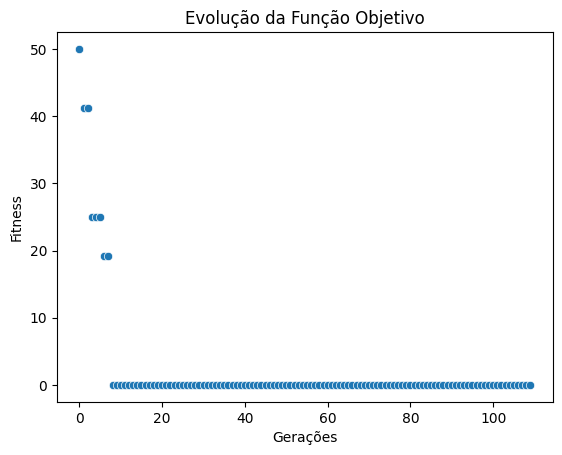

In [107]:
# Geração de malha e cálculo da função fitness
x_mesh, y_mesh = np.meshgrid(np.linspace(*params['intervals'][0], 100),
                             np.linspace(*params['intervals'][1], 100))
z_mesh = fitness_function([x_mesh, y_mesh])

# Preparação dos pontos para exibição
points = np.column_stack((bests, np.apply_along_axis(fitness_function, 1, bests)))
x_points, y_points, z_points = points[:, 0], points[:, 1], points[:, 2]

# Criação do gráfico 3D
fig = go.Figure(data=[go.Surface(x=x_mesh, y=y_mesh, z=z_mesh, opacity=0.7),
                      go.Scatter3d(x=x_points, y=y_points, z=z_points, mode='markers', marker=dict(size=5, color='red'), name='Points')],
                layout=go.Layout(title="Fitness Function 3D Plot", scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Fitness')))
fig.show()

# Plot da evolução da função objetivo
sns.scatterplot(x=np.arange(len(z_points)), y=z_points)
plt.xlabel('Gerações')
plt.ylabel('Fitness')
plt.title('Evolução da Função Objetivo')
plt.show()

## Comparações


--------------------------------------------

        ALGORITMO GENÉTICO DO PYTHON

--------------------------------------------

 The best solution found:
 [ 0.00425217 -0.00207727]

 Objective function:
 0.0022326777064254344


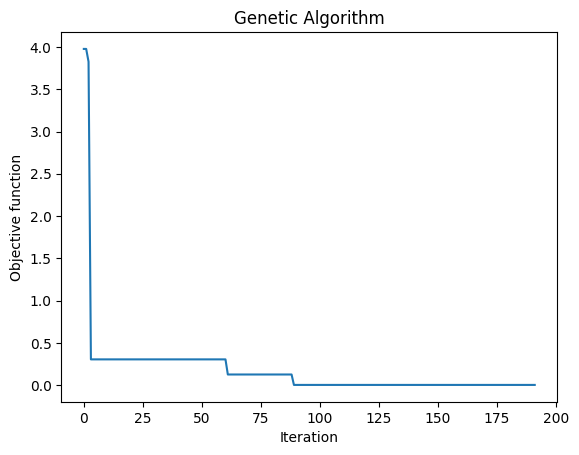

In [108]:
!pip install -q geneticalgorithm
from geneticalgorithm import geneticalgorithm as ga
# Definindo a função de fitness
print('\n--------------------------------------------\n')
print('        ALGORITMO GENÉTICO DO PYTHON')
print('\n--------------------------------------------\n')

varbound=np.array([[-5,5]]*2)

algorithm_param = {'max_num_iteration': 1000,'population_size':100,'mutation_probability':0.02,
                    'elit_ratio': 0.01,'crossover_probability': 0.5,'parents_portion': 0.5,
                    'crossover_type':'uniform','max_iteration_without_improv':100}

model=ga(function=fitness_function,dimension=2,variable_type='real',
          variable_boundaries=varbound, algorithm_parameters=algorithm_param)

model.run()